In [3]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits

/home/rasmuslovstad/Programs/assignments/thesis/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Adjust as needed
SAMPLE_PATH = "../samples/2025-02-11T14:48:45.250012"
SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

# Load models

In [18]:
models = []
key = jax.random.PRNGKey(SEED)
dataset_keys = jax.random.split(key, len(os.listdir(SAMPLE_PATH)))
for key, dataset_name in zip(dataset_keys, os.listdir(SAMPLE_PATH)):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    model_keys = jax.random.split(key, len(os.listdir(os.path.join(SAMPLE_PATH, dataset_name))))
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-3:] == ".nc":
                model_key = key
                model_name = "_".join(file_name.split("_")[:-1])
                model = bnns.model_configs.__dict__[model_name]
                split_ind = int(file_name.split("_")[-1].split(".")[0])
                az_data = az.from_netcdf(os.path.join(SAMPLE_PATH, dataset_name, file_name))
                samples = az_data.to_dict()["posterior"]
                models.append({"dataset": dataset_name, "model": model_name, "split": split_ind, "az_data": az_data, "samples": samples})

# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [19]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]
    train_X = dataset.data[train_split][:, :-1]
    train_y = dataset.data[train_split][:, -1]
    test_X = dataset.data[test_split][:, :-1]
    test_y = dataset.data[test_split][:, -1]

    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y, batch_ndims=2, parallel=True)["y"]
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y, batch_ndims=2, parallel=True)["y"]
    predictive = Predictive(model, posterior_samples=samples, return_sites=["y"], batch_ndims=2, parallel=True)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y"]
    rmse = jnp.sqrt(((test_y - predicted_ys)**2).mean())
    d["train_nll"] = train_nll.mean()
    d["test_nll"] = test_nll.mean()
    d["rmse"] = rmse.mean()
pd.DataFrame(table)

,dataset,model,split,train_nll,test_nll,rmse
0,boston-housing,UCI_FFT_CBNN_2_50,0,1785.321,1058.5862,16.790428
1,boston-housing,UCI_FFT_CBNN_2_50,1,4451.7373,3605.4937,28.855694
2,boston-housing,UCI_FFT_CBNN_2_50,2,1040.2998,951.1684,23.988714
3,boston-housing,UCI_FFT_CBNN_2_50,3,4317.6426,4467.037,40.348175


# ArviZ posterior predictive check

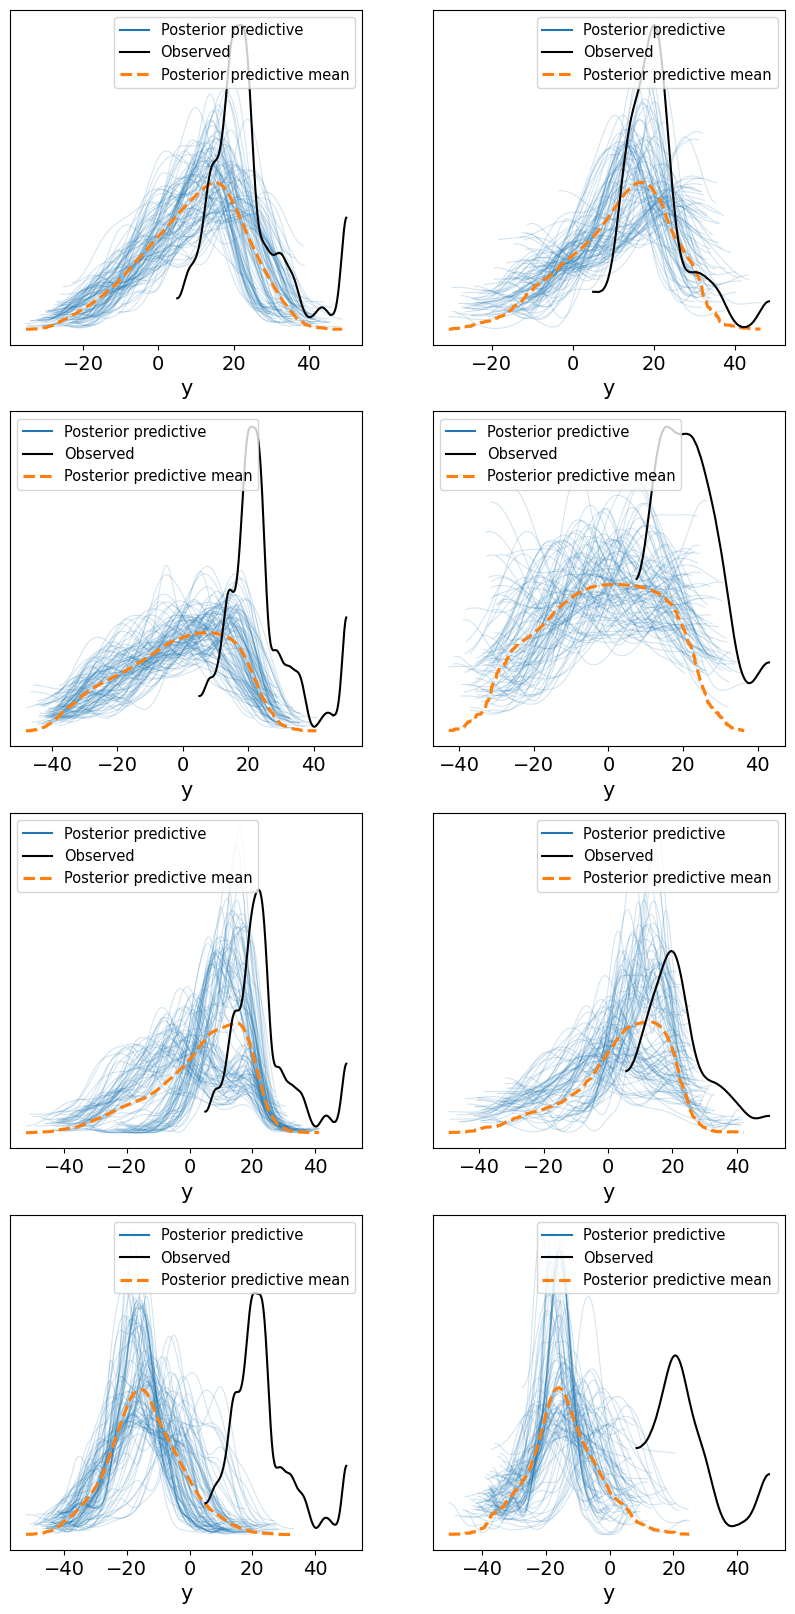

In [20]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(10, 5*len(models)))
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]
    train_X = dataset.data[split["tr"]][:, :-1]
    train_y = dataset.data[split["tr"]][:, -1]
    test_X = dataset.data[split["te"]][:, :-1]
    test_y = dataset.data[split["te"]][:, -1]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde")
    

# MCMC diagnostics

In [14]:
d["az_data"]

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data